In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/src/" /content
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/data/" /content

In [70]:
import sys
sys.path.append('.')

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
print(torch.__version__)

from src.dataset import ImageDataset
from src.config import Config

cfg = Config()

2.2.1+cu121


In [72]:
# Training dataset
train_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=True, transform=cfg.TRANSFORM_TRAIN)
# Testing/validation dataset
test_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=False, transform=cfg.TRANSFORM_TEST)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 151
Number of testing samples: 70


In [73]:
from torch.utils.data import DataLoader

# no num_workers or some weird stuff
train_dataloader_display = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_dataloader_display = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

Feature batch shape: torch.Size([1, 3, 80, 80])
Labels batch shape: torch.Size([1])
Label: 0


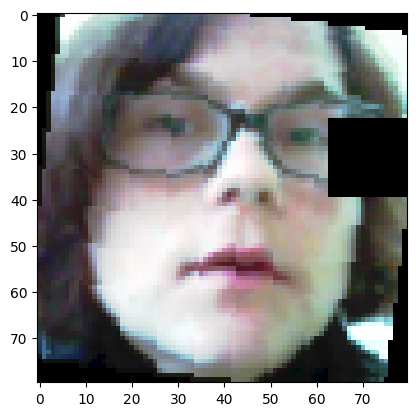

In [45]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader_display))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [74]:
# no num_workers or some weird stuff
train_dataloader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, pin_memory=True)

In [75]:
from torch.optim import SGD, Adam
from src.models.resnet9 import ResNet9
from src.models.convmixer import ConvMixer
from src.models.preact_resnet import PreActResNet18

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print('Using CPU')

model_preact_resnet18 = PreActResNet18().to(device)
# model_convmixer = ConvMixer(768, 32).to(device)
# model_resnet9 = ResNet9(3, cfg.NUM_CLASSES).to(device)
optimizer_sgd = SGD(model_preact_resnet18.parameters(), lr=0.000025, momentum=cfg.MOMENTUM, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)

Tesla T4


In [69]:
print(model_preact_resnet18.count_parameters())
#print(model_convmixer.count_parameters())
#print(model_resnet9.count_parameters())

11167042


In [76]:
from src.trainmodel import train

print(f"Training on {len(train_dataset)} samples and validating on {len(test_dataset)} samples")
history, best_model_w, best_epoch = train(model_preact_resnet18, train_dataloader, test_dataloader, 369, optimizer_sgd,
       device, cfg, grad_clip=cfg.GRAD_CLIP, verbose=True)

Training on 151 samples and validating on 70 samples
New best model found! Loss: 1.4149
[Epoch: 01/369] - 0.94s | LR: 0.000025 | Train Loss: 0.6953 | Train Acc: 47.14 | Test Loss: 0.7196 | Test Acc: 14.29
New best model found! Loss: 1.2039
[Epoch: 02/369] - 0.86s | LR: 0.000025 | Train Loss: 0.5463 | Train Acc: 86.07 | Test Loss: 0.6575 | Test Acc: 85.71
New best model found! Loss: 0.9399
[Epoch: 03/369] - 0.84s | LR: 0.000025 | Train Loss: 0.4293 | Train Acc: 86.70 | Test Loss: 0.5106 | Test Acc: 85.71
New best model found! Loss: 0.8462
[Epoch: 04/369] - 0.80s | LR: 0.000025 | Train Loss: 0.4437 | Train Acc: 85.89 | Test Loss: 0.4024 | Test Acc: 85.71
New best model found! Loss: 0.7760
[Epoch: 05/369] - 0.76s | LR: 0.000025 | Train Loss: 0.4044 | Train Acc: 86.70 | Test Loss: 0.3716 | Test Acc: 85.71
[Epoch: 06/369] - 0.77s | LR: 0.000025 | Train Loss: 0.4758 | Train Acc: 86.70 | Test Loss: 0.3757 | Test Acc: 85.71
[Epoch: 07/369] - 0.77s | LR: 0.000025 | Train Loss: 0.4847 | Train Ac

In [82]:
# continue training from best model using lower lr
model_preact_resnet18.load_state_dict(best_model_w)
optimizer_sgd = SGD(model_preact_resnet18.parameters(), lr=0.00000025, momentum=cfg.MOMENTUM, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)
history, best_model_w, best_epoch = train(model_preact_resnet18, train_dataloader, test_dataloader, 70, optimizer_sgd,
       device, cfg, grad_clip=cfg.GRAD_CLIP, verbose=True)

New best model found! Loss: 0.0706
[Epoch: 01/70] - 0.82s | LR: 0.000000 | Train Loss: 0.0662 | Train Acc: 97.14 | Test Loss: 0.0044 | Test Acc: 100.00
New best model found! Loss: 0.0211
[Epoch: 02/70] - 0.76s | LR: 0.000000 | Train Loss: 0.0159 | Train Acc: 99.37 | Test Loss: 0.0052 | Test Acc: 100.00
[Epoch: 03/70] - 0.76s | LR: 0.000000 | Train Loss: 0.0164 | Train Acc: 99.37 | Test Loss: 0.0066 | Test Acc: 100.00
[Epoch: 04/70] - 0.76s | LR: 0.000000 | Train Loss: 0.0147 | Train Acc: 99.37 | Test Loss: 0.0110 | Test Acc: 100.00
[Epoch: 05/70] - 0.77s | LR: 0.000000 | Train Loss: 0.0185 | Train Acc: 99.37 | Test Loss: 0.0084 | Test Acc: 100.00
New best model found! Loss: 0.0180
[Epoch: 06/70] - 0.77s | LR: 0.000000 | Train Loss: 0.0132 | Train Acc: 100.00 | Test Loss: 0.0048 | Test Acc: 100.00
[Epoch: 07/70] - 0.76s | LR: 0.000000 | Train Loss: 0.0215 | Train Acc: 98.75 | Test Loss: 0.0047 | Test Acc: 100.00
[Epoch: 08/70] - 0.77s | LR: 0.000000 | Train Loss: 0.0227 | Train Acc: 99.

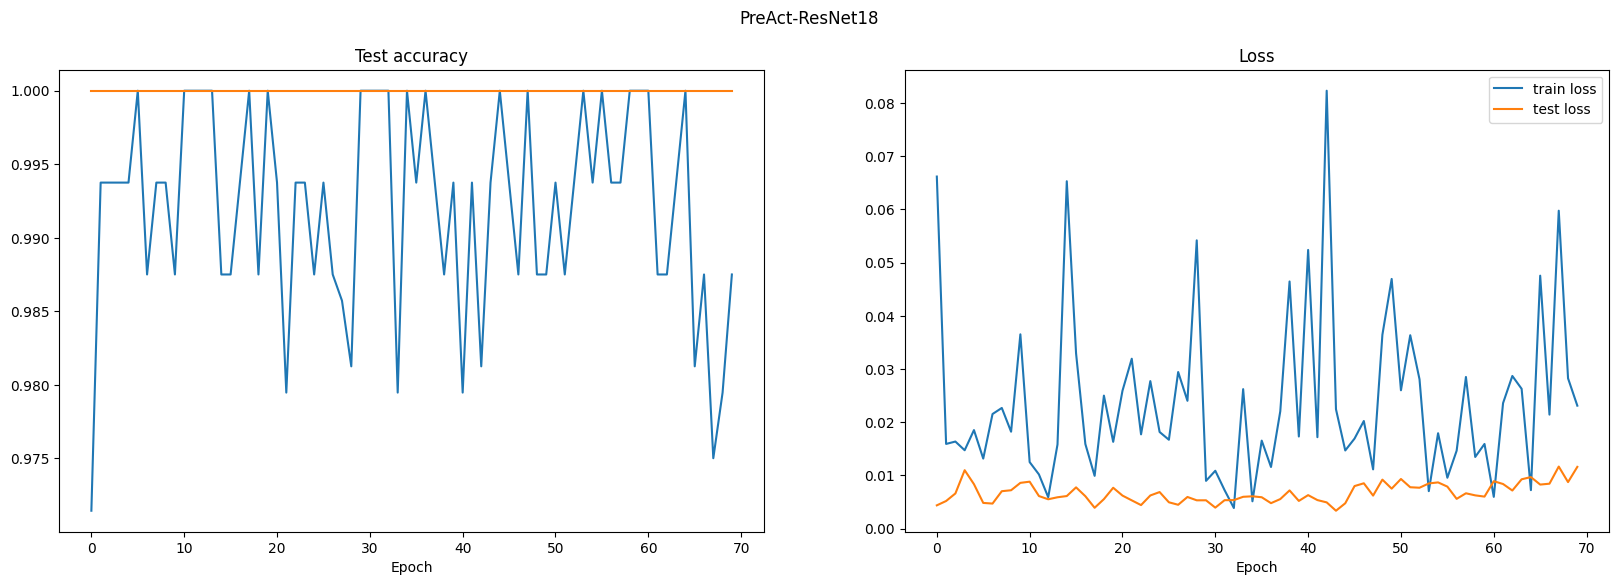

In [83]:
from src.utils import plot_graphs

plot_graphs(history, "PreAct-ResNet18")

In [84]:
# save model
from src.trainmodel import save_model
gdrive_path = '/content/drive/MyDrive/Colab Notebooks/sur/checkpoints/'

model_preact_resnet18.load_state_dict(best_model_w)
save_model(model_preact_resnet18, optimizer_sgd, cfg.EPOCHS, gdrive_path+f"img_model-PreAct-ResNet18-{best_epoch}e", history)